In [4]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import sys
from geopy import distance
from shapely.geometry import Point
import geopandas
from tqdm import tqdm
import random
import os
%matplotlib inline

In [5]:
tqdm.pandas()
os.chdir('..')

In [6]:
# import data
df = pd.read_csv('ENG_DATA/CLEANED/12-1_Clean_df.csv', index_col = [0])
df_crime = pd.read_csv('RAW_DATA/crime-sample.csv', index_col = [0])
df_school = pd.read_csv('ENG_DATA/CLEANED/school-data-cleaned.csv', index_col = [0])

In [8]:
df = df.drop(columns = ['roi', 'geometry', 'name', 'num_incidents'])

In [12]:
df["lot_acres"].fillna(df["lot_acres"].mean(), inplace=True)
df["zoning"].fillna("OTHR", inplace=True)

In [14]:
# Add year on-market, month on-market and year sold, month sold
def computeDateFunc(date, month_not_year): 
    date_format = "%m/%d/%y"
    a = datetime.strptime(date, date_format)
    if month_not_year: 
        return a.month
    else:
        return a.year

In [16]:
df["on_market_year"] = df["on_market_date"].apply(lambda x: computeDateFunc(x, False))
df["on_market_month"] = df["on_market_date"].apply(lambda x: computeDateFunc(x, True))
df["sale_year"] = df["sale_date"].apply(lambda x: computeDateFunc(x, False))
df["sale_month"] = df["sale_date"].apply(lambda x: computeDateFunc(x, True))

In [20]:
# reorder columns 
col_list = ['longitude',
 'latitude',
 'elevation',
 'full_address',
 'city',
 'street_name',
 'zip',
 'area',
 'district_no',
 'subdist_no',
 'on_market_date',
 'cdom',
 'sale_date',
 'rooms',
 'baths',
 'beds',
 'lot_acres',
 'year_built',
 'zoning',
 'drive_side',
 'parking',
 'park_leased',
 'num_parking',
 'shopping',
 'transportation',
 'type',
 'views',
 'days_on_market',
 'on_market_year',
 'on_market_month',
 'sale_year',
 'sale_month', 
 'orig_list_price', 
 'sale_price']
df = df[col_list]

In [22]:
#import geographical data 
sf = geopandas.read_file('RAW_DATA/sf.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.drop(columns = ['link'])
sf = sf.rename(columns={'name':'neighborhood'}).set_geometry('geometry')

In [24]:
sf_boundary = geopandas.read_file('RAW_DATA/sf-boundary.geojson')
sf_boundary.crs = {'init': 'epsg:4326'}
sf_boundary = sf_boundary.set_geometry('geometry')

In [28]:
df_crime['geometry'] = df_crime.apply(lambda row: Point(row['X'], row['Y']), axis=1)
df_school['geometry'] = df_school.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

In [29]:
geo_crime = geopandas.GeoDataFrame(df_crime, geometry='geometry')
geo_crime.crs = {'init': 'epsg:4326'}
geo_school = geopandas.GeoDataFrame(df_school, geometry='geometry')
geo_school.crs = {'init': 'epsg:4326'}
geo_df = geopandas.GeoDataFrame(df, geometry='geometry')
geo_df.crs = {'init': 'epsg:4326'}

In [40]:
def plot_spatial(geo__, title = None):
    # fig, ax = plt.subplots(1, figsize=(13,10))
    fig, ax = plt.subplots(1, figsize=(13,10))
    sf_map = sf.plot(ax=ax, color='white', edgecolor='black')
    geo__.plot(ax=sf_map, marker="o", markersize=8, alpha=0.3)
    if title: 
        ax.set_title(title)
    plt.show()

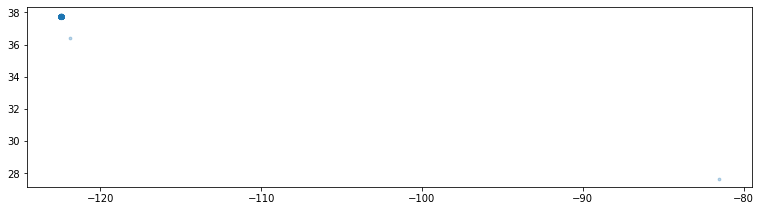

In [33]:
#drop data points that are not in boundary 
plot_spatial(geo_df)

In [34]:
geo_df.shape[0]

23717

In [35]:
geo_df_boundary = geopandas.tools.sjoin(geo_df, sf_boundary, op = 'within')

In [37]:
# dropped 15 sales
geo_df_boundary.shape[0]

23702

In [87]:
geo_df_boundary = geo_df_boundary.drop(columns = 'index_right')

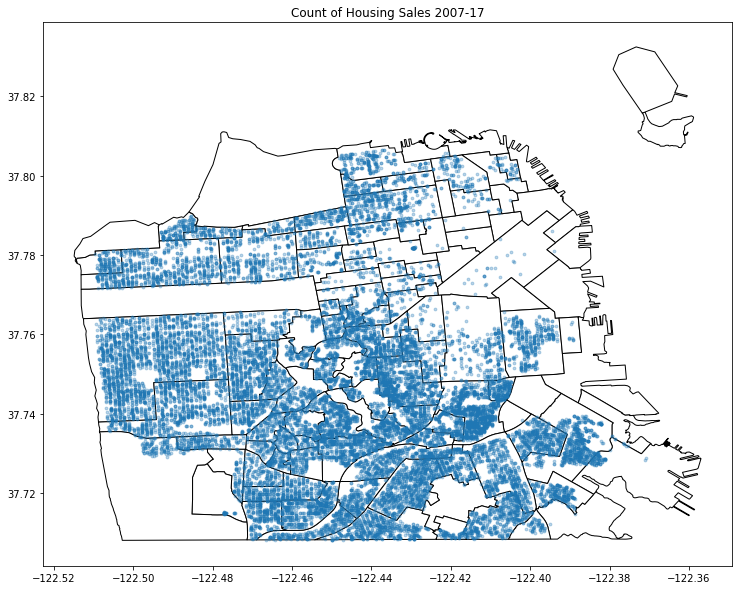

In [42]:
plot_spatial(geo_df_boundary, title = "Count of Housing Sales 2007-17")

In [43]:
geo_crime = geopandas.tools.sjoin(geo_crime, sf, how='left')

In [45]:
geo_crime = geo_crime.drop(columns = ['index_right'])

In [46]:
geo_crime.to_csv('ENG_DATA/CLEANED/crime-sample-by-neighborhood.csv')

In [49]:
geo_school = geo_school.drop(columns = ['index_right'])

In [50]:
geo_school = geopandas.tools.sjoin(geo_school, sf, how='left')

In [52]:
geo_school = geo_school.drop(columns = ['index_right'])

In [53]:
geo_school.to_csv('ENG_DATA/CLEANED/school-by-neighborhood.csv')

In [77]:
school_rating_by_neighborhood = geo_school.groupby('neighborhood')['gsRating'].mean().reset_index()

In [76]:
school_by_neighborhood = geo_school.groupby(['neighborhood', 'type'])['gsId'].count().reset_index().pivot(index='neighborhood', columns='type', values='gsId').fillna(0).reset_index()

In [80]:
school_by_neighborhood = school_by_neighborhood.merge(school_rating_by_neighborhood, on = 'neighborhood', how = 'left')

In [135]:
school_by_neighborhood = school_by_neighborhood.merge(geo_school.groupby('neighborhood')['enrollment'].mean().reset_index(), on = 'neighborhood', how = 'left')

In [137]:
school_by_neighborhood.to_csv('ENG_DATA/CLEANED/school-data-by-neighborhood.csv')

In [91]:
geo_crime.columns

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'PdId', 'geometry',
       'neighborhood'],
      dtype='object')

In [114]:
crime_by_neighborhood = geo_crime.groupby(['neighborhood', 'Category'])['IncidntNum'].count().reset_index().pivot(index='neighborhood', columns='Category', values='IncidntNum').fillna(0).reset_index()

In [140]:
cols = list(crime_by_neighborhood)

In [119]:
crime_by_neighborhood['totalIncidents']=crime_by_neighborhood.loc[:,cols[1:]].sum(axis=1)

In [141]:
crime_by_neighborhood.columns = [x.lower() for x in crime_by_neighborhood.columns]

In [142]:
crime_by_neighborhood.to_csv('ENG_DATA/CLEANED/crime-data-by-neighborhood.csv')

In [ ]:
#perform spatial join of neighborhoods to df

In [138]:
df_clean = geopandas.tools.sjoin(geo_df_boundary, sf, how='left')

In [139]:
df_clean.columns

Index(['longitude', 'latitude', 'elevation', 'full_address', 'city',
       'street_name', 'zip', 'area', 'district_no', 'subdist_no',
       'on_market_date', 'cdom', 'sale_date', 'rooms', 'baths', 'beds',
       'lot_acres', 'year_built', 'zoning', 'drive_side', 'parking',
       'park_leased', 'num_parking', 'shopping', 'transportation', 'type',
       'views', 'days_on_market', 'on_market_year', 'on_market_month',
       'sale_year', 'sale_month', 'orig_list_price', 'sale_price', 'geometry',
       'index_right', 'neighborhood'],
      dtype='object')

In [143]:
df_clean = df_clean.merge(school_by_neighborhood, on = 'neighborhood', how = 'left')
df_clean = df_clean.merge(crime_by_neighborhood, on = 'neighborhood', how = 'left')

In [144]:
df_clean = df_clean.drop(columns = ['geometry','index_right'])

In [145]:
df_clean.to_csv('ENG_DATA/CLEANED/12-8_Cleaned_df.csv')